# FOMC Transcripts and Text Analysis

This notebook aims to replicate parts of the text analysis performed in the QJE's paper written by Stephen Hansen, Michael McMahon and Andrea Prat and published in 2018. A link to the article can be found [here](https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm).

The paper analyzes how making the Federal Reserve monetary policy meetings more **transparent** affects policymakers' incentives and their between-peer discussions. The study is motivated by an ambiguous answer to that question, as theory highlights two potential channels through which transparency can affect performance:
- **Discipline**: Enhanced transparency may incentivize effort and relevant contributions
- **Conformity**: Enhanced transparency may discourage broad and creative debate

The authors exploit a change in the Federal Reserve's disclosure policy in 1993 to identify changes in behavior linked to the release of FOMC minutes data hitherto undisclosed. A simple natural experiment set-up with which authors are able to observe some interesting patterns:

- Inexperienced members show increased discipline and an enhanced focus on quantitative subjects when discussing economic prospects
- These same members engage in conformity when discussing tangible policy actions
- Overall, the former effect seems to dominate

### Background

- The FOMC is the main policy body of the Federal Reserve System and meets eight times a year to draft monetary policy
- Although the meetings were recorded, prior to 1993 it was believed that these recordings where destroyed
- However, Greenspan 'discovered' in 1993 that these were first transcribed and only then destroyed
- Within months of the revelation, the Fed agreed to publish all past transcripts and to release any transcripts henceforth with a five-year lag

## Python Script

In [1]:
# Load packages

# Basics
import re                                                               # built-in regular expressions
import os                                                               # built-in operating system interfaces
import numpy as np                                                      # for everything matrix-related
import pandas as pd                                                     # data manipulation and analysis
pd.set_option('display.max_columns', None)                              # Show all columns on display

# nltk
import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords                                       # Importing stopwords

# Plotting
import matplotlib.pyplot as plt                                         # Plotting library
import seaborn as sns                                                   # High-end plotting based on matplotlib
from wordcloud import WordCloud                                         # Visualize word frequencies

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer             # Convert raw documents to TF-IDF matrix of features
from sklearn.decomposition import LatentDirichletAllocation             # LDA using variational inference (vs. MCMC)

# Misc
from tqdm import tqdm                                                   # Progress bar for loops

In [2]:
# Define Directory - Change accordingly
maindir = 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/'
datadir = maindir + 'data/'

### Build dataframe

Including in this replication is a list of years containing transcripts from all FOMC meetings. These are readily available [here](https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm). In order to keep the focus of the class narrow, steps to scrape the webpage and the use of OCR to transform to txt format are omitted here, but I can provide the script upon request. 

In [3]:
# Fetch all paths where the transcripts are stored
dict_transcripts = {}                                                 # A dictionary to feed

for year in range(1982, 2008):
    
    transcripts = []                                                  # A list to feed
    
    pwd = datadir + str(year)                                         # Update print working directories

    year_transcripts = os.walk(pwd)                                   # Walk into year-specific print working directory
    
    for item in year_transcripts:                                     # (Actually it only finds one per year)
        for file in item[2]:                                          # Iterate over individual files found in a given pwd
                    transcripts.append(str(item[0]) + "/" + file)     # Append to dictionary
    dict_transcripts[str(year)] = transcripts                         # Feed list
    
transcript_list = []                                                  # A list to feed using dictionary

for item in dict_transcripts.values():                                # Iterate over dictionary
    transcript_list += item                                           # Add key and value to list
    
transcript_list = sorted(transcript_list)                             # Sort transcripts

print("Length of Documents:", len(transcript_list))

Length of Documents: 209


In [4]:
transcript_list[:20]

['E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19820202meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19820330meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19820518meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19820701meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19820824meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19821005meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19821116meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1982/FOMC19821221meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1983/FOMC19830209meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1983/FOMC19830329meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1983/FOMC19830524meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1983/FOMC19830713meeting.txt',
 'E:/Dropbox/_Pre-Doc/NLP_course/GSE/FOMC/data/1983/FOMC19830823

In [5]:
# A look at the body of the first document
infile = open(transcript_list[0], encoding="utf8")                    # Built-in function to open txt files
text = infile.readlines()                                             # Return all lines as a list

text = [line.strip() for line in text]                                # Remove any spacing either side of each line
text = ' '.join(text)                                                 # Join lines using a space as separator

print(text)                                                           # Print

Meeting of the Federal Open Market Committee February 1-2, 1982  A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D. C., starting on Monday, February 1, 1982, at 2:30 p.m. and continuing on Tuesday, February 2, 1982, at 9:00 a.m. PRESENT:  Mr. Volcker, Chairman Mr. Solomon, Vice Chairman Mr. Boehne Mr. Boykin Mr. Corrigan Mr. Gramley Mr. Keehn Mr. Partee Mr. Rice Mr. Schultz Mrs. Teeters Mr. Wallich Messrs. Balles, Black, Ford, Timlen, and Winn, Alternate Members of the Federal Open Market Committee Messrs. Guffey, Morris, 1/ and Roos, Presidents of the Federal Reserve Banks of Kansas City, Boston, and St. Louis, respectively Mr. Axilrod, Staff Director Mr. Altmann, Secretary Mr. Bernard, Assistant Secretary Mrs. Steele, Deputy Assistant Secretary Mr. Bradfield, General Counsel Mr. Mannion, Assistant General Counsel Mr. Kichline, Economist Messrs. Burns, Ettin, 2/ Mullineaux, Prell, Scheld, Tru

In [6]:
# Create large dataframe that splits statements and assigns author
appended_data = []                                                    # List to feed

for item in tqdm(transcript_list):

    infile = open(item, encoding="utf8")                              # Built-in function to open txt files
    text = infile.readlines()                                         # Return all lines as a list

    text = [line.strip() for line in text]                            # Remove any spacing either side of each line
    text = ' '.join(text)                                             # Join lines using a space as separator

    # Split text on any FOMC member being named using upper-case. Then store name and subsequent paragraph until next split
    splits=re.split('(?=MS. [A-Z]+.|MR. [A-Z]+.|CHAIRMAN [A-Z]+.|VICE CHAIRMAN [A-Z]+.|SPEAKER\(\?\))(MS. [A-Z]+.|MR. [A-Z]+.|CHAIRMAN [A-Z]+.|VICE CHAIRMAN [A-Z]+.|SPEAKER\(\?\))',text)

    dft=splits[1:-20]                                                 # Ignore first paragraph (intro) and end-document noise

    member, statement = dft[::2], dft[1::2]                           # Split in two lists (recall arguments [start:end:step])

    dft = list(zip(member, statement))                                # Join them again as tuples (member-statement pairs)

    dft = pd.DataFrame(dft,columns = ['member','statement'])          # Transform into a Pandas DataFrame
    dft['date'] = re.search('FOMC(\d+)meeting',item).group(1)         # Store the date of the meeting (using regex in file name)

    appended_data.append(dft)                                         # Append data to the list
    
appended_data = pd.concat(appended_data)                              # Concatenate all pandas DF stored in the list

100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [00:10<00:00, 19.83it/s]


In [7]:
appended_data.head(20)

,member,statement,date
0,CHAIRMAN VOLCKER.,Do we have any comments or questions on how t...,19820202
1,VICE CHAIRMAN SOLOMON.,in most or all of these new wage agreements t...,19820202
2,MR. ZEISEL.,"Yes, it is apparently a fairly common part of...",19820202
3,CHAIRMAN VOLCKER.,You have the line for compensation per hour g...,19820202
4,MR. ZEISEL.,"Well, it's not entirely in the future, but We...",19820202
5,CHAIRMAN VOLCKER.,The Federal Reserve had a bigger increase in ...,19820202
6,MR. ZEISEL.,,19820202
7,MR. GRAMLEY.,"Well, it's hard to know, but one can-The Fed...",19820202
8,MR. ZEISEL.,The kinds of adjustments that President Solom...,19820202
9,CHAIRMAN VOLCKER.,"Yes, we see some signs of this, and some wage...",19820202


### Checks

In [8]:
print('Size:', appended_data.shape)

# Duplicates, NAN
print('Duplicated entries:', appended_data.duplicated().any())
appended_data.head(5)

Size: (76080, 3)
Duplicated entries: True


,member,statement,date
0,CHAIRMAN VOLCKER.,Do we have any comments or questions on how t...,19820202
1,VICE CHAIRMAN SOLOMON.,in most or all of these new wage agreements t...,19820202
2,MR. ZEISEL.,"Yes, it is apparently a fairly common part of...",19820202
3,CHAIRMAN VOLCKER.,You have the line for compensation per hour g...,19820202
4,MR. ZEISEL.,"Well, it's not entirely in the future, but We...",19820202


In [9]:
# Keep only rows with more than 50 characters
appended_data = appended_data.loc[appended_data['statement'].str.len() >=50].reset_index(drop = True)

In [10]:
print('Size:', appended_data.shape)

# Duplicates, NAN
print('Duplicated entries:', appended_data.duplicated().any())

Size: (50601, 3)
Duplicated entries: True


In [11]:
# Number of duplicated entries
print('Number of duplicated entries:',len(appended_data.loc[appended_data.duplicated() == True]))

# Drop the two odd observations
appended_data = appended_data.loc[appended_data.duplicated() == False]

Number of duplicated entries: 2


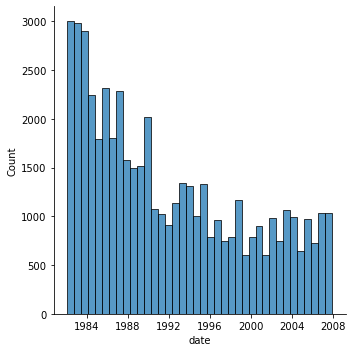

In [12]:
# Visualize distribution of statements - Create datetime column
appended_data['date'] = pd.to_datetime(appended_data['date'], format='%Y%m%d')

# Visualize distribution of statements - Histogram plot
sns.displot(appended_data, x="date")

## Text Pre-Processing

The script above fetched the data and appended it in a single, tractable dataframe. The next natural step in all text analysis applications is to pre-process the corpus of data. Note that, in order to streamline our text pre-processing tasks, we omit the part-of-speech tagger process described in section IV. B. In case you are interested, you can find a more detailed description [here](https://nlp.stanford.edu/pubs/tagging.pdf) and an NLTK implementation [here](http://www.nltk.org/book/ch05.html).

In [13]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
stop_words = stopwords.words('english')
stop_words.append('think')
stemmer      = SnowballStemmer('english')

In [14]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    doc        = doc.replace('</br>', ' ')
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop]         # normalize numbers
    stem_text  = [stemmer.stem(w) for w in no_numbers]                   # stem each word
    
    return stem_text

In [15]:
# Pass all statements through the pre-processing function
statements = []                                                          # Create list to feed

for doc in tqdm(appended_data['statement']):                             # Iterate over statement-sized documents
    
    raw_wip = normalize_text(doc)                                        # Call in normalize_text function on doc
    statements.append(raw_wip)                                           # Append to list
    
statements_clean = [" ".join(item) for item in statements]               #Convert each string-list to an actual string
print(type(statements_clean), len(statements_clean))

# Create additional column in the speeches DF that is the pre-processed speeches
appended_data["statements_clean"] = statements_clean                     # Create column in DataFrame containing list

100%|███████████████████████████████████████████████████████████████████████████| 50599/50599 [01:30<00:00, 561.28it/s]


<class 'list'> 50599


In [16]:
# Check a handful of rows in our pre-processed corpus
appended_data.head(10)

,member,statement,date,statements_clean
0,CHAIRMAN VOLCKER.,Do we have any comments or questions on how t...,1982-02-02,comment question peopl see thing question unde...
1,VICE CHAIRMAN SOLOMON.,in most or all of these new wage agreements t...,1982-02-02,new wage agreement come much lower level teams...
2,MR. ZEISEL.,"Yes, it is apparently a fairly common part of...",1982-02-02,yes appar fair common part limit number agreem...
3,CHAIRMAN VOLCKER.,You have the line for compensation per hour g...,1982-02-02,line compens per hour go pretti steepli futur ...
4,MR. ZEISEL.,"Well, it's not entirely in the future, but We...",1982-02-02,well entir futur your perfect right larg degre...
5,CHAIRMAN VOLCKER.,The Federal Reserve had a bigger increase in ...,1982-02-02,feder reserv bigger increas compens look forwa...
6,MR. GRAMLEY.,"Well, it's hard to know, but one can-The Fed...",1982-02-02,well hard know one canth feder reserv recess h...
7,MR. ZEISEL.,The kinds of adjustments that President Solom...,1982-02-02,kind adjust presid solomon mention minut ago s...
8,CHAIRMAN VOLCKER.,"Yes, we see some signs of this, and some wage...",1982-02-02,yes see sign wage agreement report newspap sug...
9,MR. SCHULTZ.,"Well, we do studies to see what the comparabl...",1982-02-02,well studi see compar salari compar salari go ...


In [17]:
#Get the TF-IDF vectors of each bi-gram and tri-gram used in the pre-processed speeches
tvec = TfidfVectorizer(analyzer     = 'word',      # Arg: feature as word (use analyzer to collapse all steps in the future!)
                       ngram_range  = (1, 3),      # Arg: a range of n-grams to extract as features 
                       stop_words   = None,        # Arg: stopwords (already removed above)
                       encoding     = "utf-8",     # Arg: Variable-width encoding
                       decode_error = "replace",   # Arg: Instruction to deal with non-UTF-8
#                        max_features = 9000,        # Arg: Maximum number of features (trick)
                       min_df       = 0.01,        # Arg: Minimum frequency of words-features
                       max_df       = 0.9          # Arg: Maximum frequency of words-features
                      )

data_tfidf = tvec.fit_transform(appended_data['statements_clean'])     # Train and transform  

X_mat = data_tfidf.todense()                                           # Output in dense format

words = tvec.get_feature_names()                                       # Store word names

In [18]:
# Resulting shape of dense matrix (rows are statements, columns are Tf-IDFed uni-grams, bi-grams and tri-grams)
X_mat.shape

(50599, 1060)

In [19]:
words[:20]

['abil',
 'abl',
 'abroad',
 'absolut',
 'acceler',
 'accept',
 'accommod',
 'accord',
 'account',
 'achiev',
 'across',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'address',
 'adjust']

## Latent Dirichlet Allocation

In order to draw estimations of **discipline** and **comformity**, the authors proceed to extract topics from FOMC members' statements. In order to do so, they resort to topic modeling, a branch of unsupervised generative NLP which is used to represent text documents as a distribution over categories of important underlying information.

The key idea with topic modeling is that documents exhibit each category (or topic) in some proportion, which we would like to learn from the data. Given that what we observe are words, it is further assumed that each topic is a distribution over words, and that using the latter we could estimate the former. As such, the objective of topic modeling is to estimate the topic-document distribution and the word-topic distribution using Bayesian inference techniques in order to find the latent thematic structure in the text. In other words, the model aims to use the observed words to infer hidden topics.

Crucially, LDA places symmetric Dirichlet priors over the two distributions. [Intuitively](https://en.wikipedia.org/wiki/Dirichlet_distribution), these priors allow documents to contain few topics and topics to use only a handful of words frequently. The resulting Dirichlet distribution can be thought of as a distribution of distributions (a multinomial generalization of a Beta-distribution), which assigns word-to-topic and topic-to-document probabilities.

In plate notation, the graphical model of LDA is a three-level generative model that looks like this:

![plate](https://scikit-learn.org/stable/_images/lda_model_graph.png)

The model assumes the following generative process for a corpus with $D$ documents and $K$ topics.

1. For each topic $k \in K$, draw $\beta_k \sim Dirichlet(\eta)$. This provides a distribution over the words

2. For each document $d \in D$, draw the topic proportions $\theta_d \sim Dirichlet(\alpha)$

3. For each word $i$ in document $d$

    1. Draw the topic assignment $z_{di} \sim Multinomial(\theta_d)$
    
    2. Draw the observed word $w_{ij} \sim Multinomial(\beta_{z_{di}})$
    
The posterior distribution corresponds to: 
$$
p(z, \theta, \beta \mid w, \alpha, \eta)=\frac{p(z, \theta, \beta \mid \alpha, \eta)}{p(w \mid \alpha, \eta)}
$$

Although the theory may be rather intimidating, implementation using high-level Python packages is extremely straightforward, as we will now see.

## LDA - Application

In [20]:
# Define number of topics K
number_of_topics = 40

# Call LDA model using sklearn's package (note no Gibbs sampling is called, an online variational Bayes algorithm is instead used)
model = LatentDirichletAllocation(n_components=number_of_topics)

# Fit the model
model.fit(X_mat)

# Transform the model
lda_output = model.transform(X_mat)

In [21]:
# Column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)]

# Create df with topic distributions
statements_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

# Snippet at a handful of document topic loadings (rows are documents, columns are unnamed topics)
statements_topic.head(20)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39
0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.16,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.56,0.01,0.01
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.23,0.01,0.01,0.01,0.01,0.01,0.53,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.48,0.01,0.01,0.01,0.01,0.01
6,0.01,0.01,0.09,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.68,0.01,0.01,0.01,0.01,0.01
7,0.07,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.71,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00
9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.66,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [22]:
# Compute Topic average loadings over the whole sample 
statements_topic.loc['Total']= statements_topic.sum()                   # A non-pythonic way of creating a rowsum
statements_share = statements_topic[-1:]/len(statements_topic.index)    # Use Total row, divide by length of docs
statements_topic.drop('Total', axis = 0, inplace = True)                # Drop temp Total row

# Reshape
statements_share = statements_share.transpose()
statements_share = statements_share.reset_index()
statements_share.columns = ['Topic', 'Share']

# Print
statements_share

,Topic,Share
0,Topic0,0.026071
1,Topic1,0.026847
2,Topic2,0.014483
3,Topic3,0.025026
4,Topic4,0.021520
5,Topic5,0.019160
6,Topic6,0.022601
7,Topic7,0.019353
8,Topic8,0.026917
9,Topic9,0.011566


In [23]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):                                 # Define show_topics function
    '''Returns a list of n words with the highest 
       weight loadings given an LDA model'''
    keywords = np.array(vectorizer.get_feature_names())                          # Create an array of names
    
    topic_keywords = []                                                          # Create a list to feed
    
    for topic_weights in lda_model.components_:                                  # Iterate over the word-weights per topic
        top_keyword_locs = (-topic_weights).argsort()[:n_words]                  # Fetch the index of the highest-weight words
        topic_keywords.append(keywords.take(top_keyword_locs))                   # Obtain the word labels and append to list
        
    return topic_keywords                                                        # Return nested list of largest-weight words

# Call function
topic_keywords = show_topics(vectorizer=tvec, lda_model=model, n_words=100)

# Topic - Keywords Dataframe (Fig. II)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81,Word 82,Word 83,Word 84,Word 85,Word 86,Word 87,Word 88,Word 89,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99
Topic 0,object,without,appendix,approv,mr,minut,thank,move,chairman,morn,meet,mr chairman,thank mr,report,thank mr chairman,question,turn,everyon,let,chart,oper,would,well,present,subject,open,discuss,peter,somebodi,open market,committe,comment,need,like,second,kohn,good,procedur,brief,us,go,domest,laughter,econom,call,manag,staff,releas,last meet,assum,start,much,mike,next,first,issu,fomc,show,situat,ill,desk,market,note,recess,refer,want,last,distribut,okay,hear,foreign,date,nomin,bring,get,dont,bill,ask,option,time,may,author,make,system,decemb,would like,address,propos,also,vice,materi,usual,today,soon,vote,governor,tabl,sinc,juli,account
Topic 1,dollar,exchang,exchang rate,rate,market,would,foreign,foreign exchang,go,interest,get,one,dont,interest rate,declin,trade,move,us,intervent,say,polici,japanes,effect,time,that,much,weaken,question,rule,well,economi,could,term,chang,thing,way,situat,awar,problem,sens,side,see,seem,may,kind,might,forecast,pressur,happen,certain,posit,realli,point,weak,lot,expect,period,know,domest,current,account,want,come,look,concern,im,easi,someth,put,valu,like,currenc,abroad,relat,reaction,make,take,level,peopl,intern,stabil,price,deficit,littl,tri,differ,view,particular,direct,even,talk,let,factor,reason,strong,rise,part,strengthen,continu,fundament
Topic 2,run,depend,short,januari,page,upon,short run,februari,recess,long,go,happen,room,well,would,littl,rate,say,progress,rate go,economi,goe,that,yes,get,could,whether,way,term,want,look,meet,aggreg,take,altern,bluebook,market,march,end,downward,dont,strength,rang,much,move,doesnt,make,rate increas,let,start,talk,see,right,expect,might,im,time,evid,increas,one,direct,thing,fall,first,read,high,differ,circumst,develop,reduc,come,give,effect,put,percent,may,money,mean,wouldnt,even,week,flexibl,probabl,thought,toward,base,cant,interest,inflat,bottom,there,longterm,guess,revers,pretti,els,account,number,stay,busi
Topic 3,million,borrow,week,season,reserv,would,adjust,level,path,target,well,billion,say,go,pressur,period,initi,assumpt,last,that,littl,averag,yes,excess,number,last week,dont,right,normal,mean,one,percent,get,higher,chang,talk,day,make,peter,might,altern,like,could,problem,assum,start,technic,come,differ,much,high,special,seem,rang,low,recent,two,way,look,market,around,net,less,run,weve,figur,bank,use,first,someth,big,inflationari,probabl,point,take,time,mayb,even,expect,guess,actual,rate,may,let,lower,want,slight,question,money,unintellig,allow,increas,wouldnt,realli,know,didnt,factor,interpret,end,im
Topic 4,tell,model,debt,us,tell us,problem,would,stop,conclus,dont,go,get,use,one,well,creat,cannot,say,that,histori,predict,troubl,gotten,difficulti,lot,way,though,thing,question,time,track,someth,realli,know,cant,power,issu,want,tri,differ,make,play,work,take,peopl,may,chang,look,im,point,type,could,even,right,might,doesnt,serious,relationship,even though,your,market,laughter,happen,yes,result,much,money,reason,number,suggest,seem,believ,sens,like,run,year,there,find,never,percent,whether,effect,situat,littl,structur,let,quit,back,move,come,variabl,give,far,put,term,anyth,measur,period,said,data
Topic 5,price,oil,okay,isnt,oil price,shock,import,would,volatil,ene

In [24]:
# Merge with member name and date
topic_data = pd.merge(appended_data[['member','date']], statements_topic, left_index=True, right_index=True)

In [25]:
# Collapse on member x date
topic_data = topic_data.groupby(['member','date']).mean().reset_index()

topic_data

,member,date,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39
0,CHAIRMAN BERNANKE.,2006-03-28,0.022292,0.004375,0.005833,0.007500,0.010625,0.004375,0.009792,0.007083,0.084583,0.004375,0.016458,0.017083,0.007083,0.004375,0.075000,0.040417,0.060000,0.004375,0.020833,0.004375,0.004375,0.004375,0.007500,0.116042,0.216667,0.004375,0.024792,0.004375,0.004375,0.024167,0.007083,0.045625,0.028542,0.004375,0.026667,0.004375,0.008750,0.017292,0.018750,0.004375
1,CHAIRMAN BERNANKE.,2006-05-10,0.031176,0.024412,0.005000,0.005000,0.005000,0.005000,0.018235,0.017647,0.137353,0.005000,0.010882,0.024412,0.005000,0.005000,0.055294,0.052647,0.005000,0.020294,0.005000,0.016471,0.005000,0.016176,0.022647,0.136471,0.179412,0.005000,0.006471,0.005000,0.005000,0.017647,0.013235,0.024706,0.012647,0.005000,0.029706,0.005000,0.005000,0.018529,0.005000,0.029118
2,CHAIRMAN BERNANKE.,2006-06-29,0.004375,0.004375,0.017188,0.004375,0.004687,0.004375,0.004375,0.004375,0.089688,0.007188,0.025313,0.004375,0.004375,0.019688,0.063750,0.124375,0.055313,0.004375,0.004375,0.004687,0.004375,0.004375,0.025938,0.199687,0.113750,0.004375,0.004375,0.013438,0.004375,0.007500,0.004375,0.067812,0.004375,0.004375,0.004375,0.004375,0.004375,0.004375,0.004375,0.060625
3,CHAIRMAN BERNANKE.,2006-08-08,0.041429,0.003810,0.003810,0.003810,0.003810,0.036190,0.003810,0.003810,0.109524,0.003810,0.033810,0.003810,0.003810,0.003810,0.067619,0.003810,0.028571,0.003810,0.039048,0.003810,0.009524,0.003810,0.003810,0.225238,0.199048,0.009524,0.003810,0.003810,0.019048,0.003810,0.010000,0.026667,0.003810,0.003810,0.003810,0.003810,0.003810,0.021429,0.003810,0.018095
4,CHAIRMAN BERNANKE.,2006-09-20,0.004000,0.038500,0.004000,0.004000,0.004000,0.011500,0.004000,0.004000,0.091500,0.004000,0.020500,0.004000,0.004000,0.004000,0.134000,0.014500,0.004000,0.004000,0.004000,0.004000,0.043000,0.004000,0.004000,0.130500,0.295000,0.004000,0.004000,0.004000,0.025000,0.004000,0.026500,0.004000,0.016000,0.004000,0.039000,0.004000,0.004000,0.004000,0.004000,0.004000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,VICE CHAIRMAN SOLOMON.,1984-07-17,0.006780,0.032203,0.030000,0.022712,0.014746,0.020169,0.010847,0.033051,0.020169,0.016780,0.017966,0.006780,0.018644,0.030847,0.006780,0.006780,0.056780,0.030169,0.047966,0.006780,0.019831,0.016610,0.022542,0.006780,0.013220,0.006780,0.021695,0.017966,0.112373,0.018983,0.025932,0.006780,0.010000,0.123051,0.028305,0.008305,0.022373,0.065593,0.006780,0.026441
5213,VICE CHAIRMAN SOLOMON.,1984-08-21,0.019545,0.030000,0.006364,0.046818,0.006364,0.066591,0.006364,0.022955,0.006364,0.006364,0.013409,0.067500,0.027500,0.045455,0.006364,0.044545,0.080909,0.016591,0.007500,0.047500,0.011818,0.026136,0.022273,0.006364,0.024318,0.014318,0.012273,0.023409,0.025227,0.009318,0.010909,0.016364,0.026364,0.006364,0.070000,0.026364,0.042500,0.006364,0.006364,0.048409
5214,VICE CHAIRMAN SOLOMON.,1984-10-02,0.014583,0.089167,0.025417,0.148333,0.066250,0.005833,0.035417,0.005833,0.005833,0.005833,0.007083,0.071250,0.005833,0.014583,0.005833,0.005833,0.005833,0.016250,0.012917,0.005833,0.021250,0.027500,0.017500,0.035000,0.031667,0.005833,0.005833,0.005833,0.015417,0.028750,0.015000,0.018750,0.033333,0.005833,0.071250,0.012500,0.021667,0.025833,0.054167,0.005833
5215,VICE CHAIRMAN SOLOMON.,1984-11-07,0.005161,0.028710,0.014194,0.122258,0.020645,0.005161,0.005161,0.018710,0.005161,0.005161,0.005161,0.197097,0.031290,0.007419,0.026452,0.005161,0.033548,0.005161,0.027419,0.005161,0.028710,0.005161,0.039032,0.005161,0.034194,0.066129,0.005161,0.025806,0.005161,0.005161,0.030645,0.014839,0.060968,0.032903,0.0

In [26]:
# Create 3 or 6-meeting rolling averages of member x statement topic coverages
for i in np.arange(0,number_of_topics):
    colname = 'Topic' + str(i) + '_RA'
    
    # Group observations by member and create column with a rolling avg
    topic_data[colname]=topic_data.groupby('member')['Topic'+str(i)].rolling(6).mean().reset_index(drop = True)       

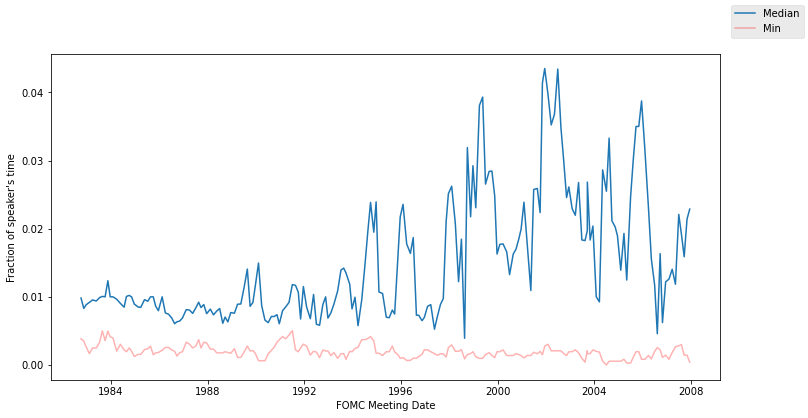

In [27]:
# Name Topic you want to plot
topic_to_plot = 'Topic14_RA'

# Create topic-specific dataframe
topic_plot=topic_data.groupby('date').agg({topic_to_plot: ['min','max','median']})
topic_plot.columns = topic_plot.columns.map('_'.join)
topic_plot = topic_plot.reset_index()

# Plot topic (Fig. III)
dates = topic_plot['date'].to_list()
topic_min = topic_plot[topic_to_plot + '_min'].to_list()
topic_max = topic_plot[topic_to_plot + '_max'].to_list()
topic_median = topic_plot[topic_to_plot + '_median'].to_list()

# Define figure
fig, ax = plt.subplots(1, 1, figsize=(12,6))

plt.style.use('ggplot')
plt.plot(dates, topic_median, c='#1f77b4', label='Median')
plt.plot(dates, topic_min, c='r', label='Min', alpha=0.3)
plt.xlabel('FOMC Meeting Date')
plt.ylabel('Fraction of speaker\'s time')
ax.figure.legend()

### WordCloud

In [28]:
# Show top n keywords for each topic (similar arguments to show_topics function)
def topics_weights(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())               # create array of names
    
    dict_topic_key_weight = {}                                        # create a dictionary to feed

    for i, topic_weights in enumerate(lda_model.components_):         # for all word weights x topic in the LDA model
        top_keyword_locs = (-topic_weights).argsort()[:n_words]       # order the list of weights and fetch the n_words largest
        
        topic_key_weight = {}                                         # nested dictionary to feed
        
        for key in top_keyword_locs:                                  # for each of the n_words highest-weight words x topic
            keyword = keywords.take(key)                              # store the word label (actual word)
            weight  = topic_weights[key]                              # store the associated word weight
            topic_key_weight[keyword] = weight                        # add key-weight pair to dictionary
            
        dict_topic_key_weight[i] = topic_key_weight                   # for topic i, add all key-weight pairs as nested dict
        
    return dict_topic_key_weight                                      # return a dictionary of K topics with n_word pairs

topic_key_weights = topics_weights(vectorizer=tvec, lda_model=model, n_words=100)

In [30]:
topic_key_weights

{0: {'object': 258.6919977036726,
  'without': 199.07572273897074,
  'appendix': 191.3272730829301,
  'approv': 183.7563982842314,
  'mr': 158.7538306961317,
  'minut': 129.38616861405225,
  'thank': 122.61302912981333,
  'move': 84.60832225645889,
  'chairman': 74.16584452180065,
  'morn': 71.82221944367637,
  'meet': 70.63510223257626,
  'mr chairman': 66.27061818306517,
  'thank mr': 61.65005277934067,
  'report': 59.731875484652974,
  'thank mr chairman': 57.5663559537345,
  'question': 54.67119762021357,
  'turn': 46.9311003639179,
  'everyon': 45.211581533876696,
  'let': 41.53663485196077,
  'chart': 37.16254845302519,
  'oper': 36.20874232371697,
  'would': 34.357169744693756,
  'well': 34.254955689218114,
  'present': 30.956328372056213,
  'subject': 30.880207056034823,
  'open': 30.351876699159643,
  'discuss': 29.52255220691346,
  'peter': 28.67797386800711,
  'somebodi': 28.435283264258842,
  'open market': 27.883448676462006,
  'committe': 27.487753995633827,
  'comment': 

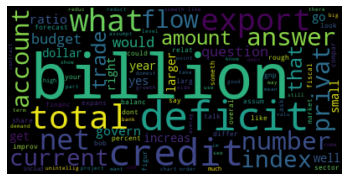

In [31]:
# Pass a topic to plot the wordcloud
topic_choice = 7

# Call in WordCloud generator
wordcloud = WordCloud().generate_from_frequencies(topic_key_weights[topic_choice])

# Plot resulting WordCloud
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Paper Results

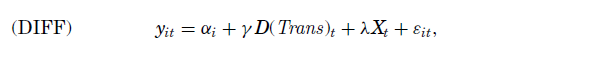
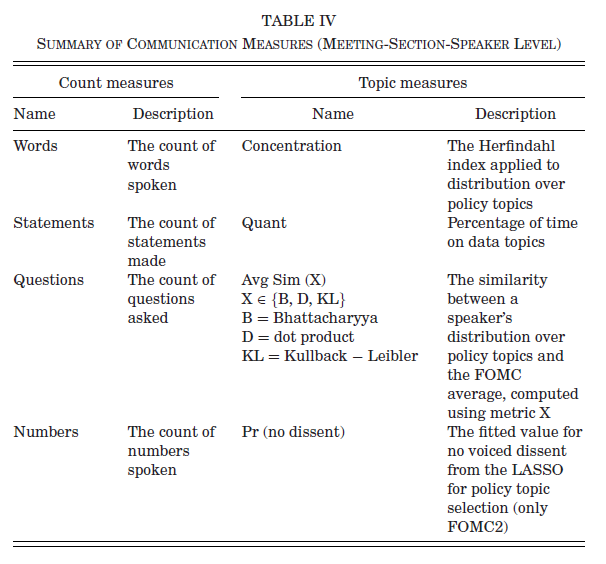
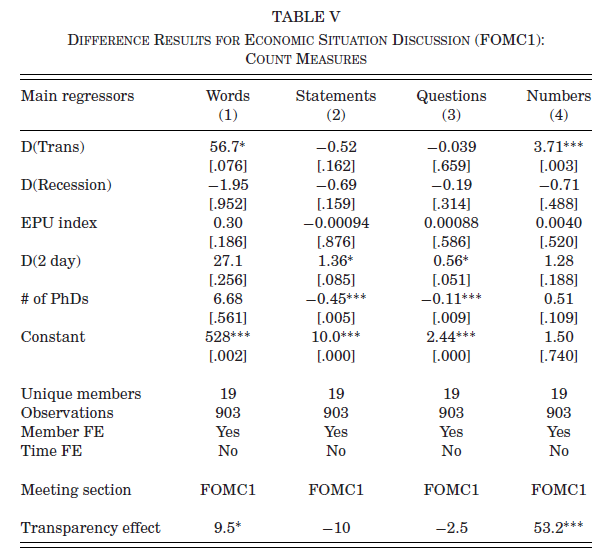
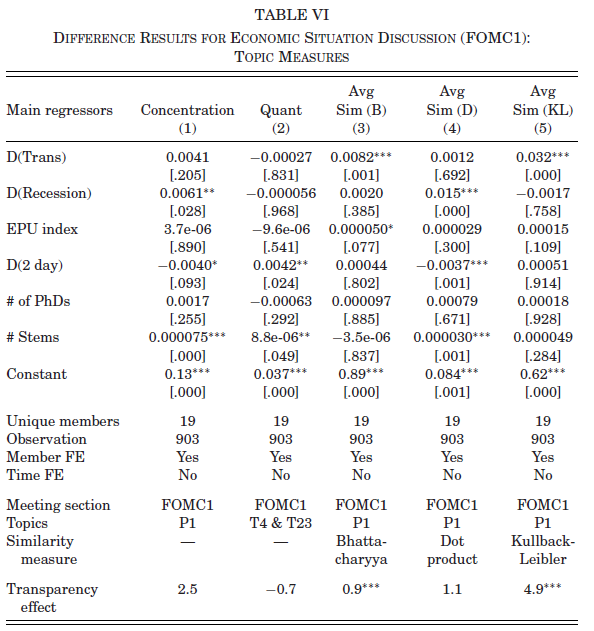
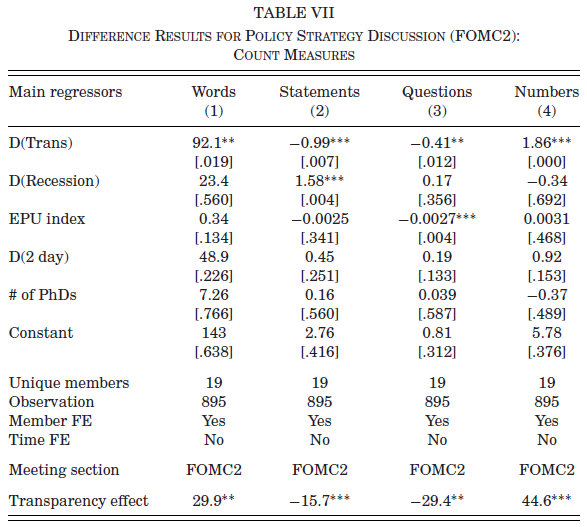
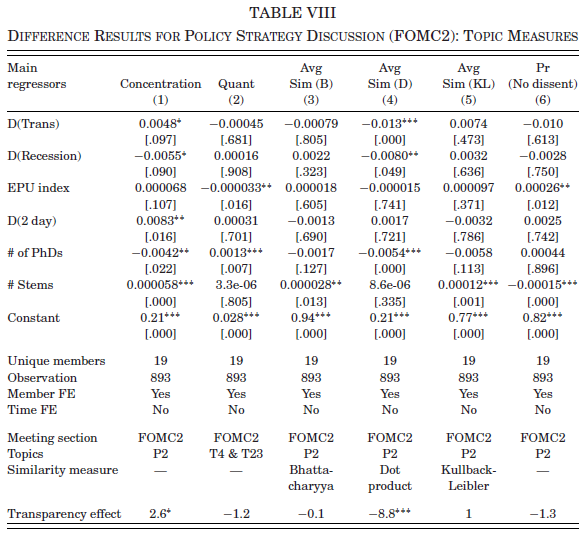
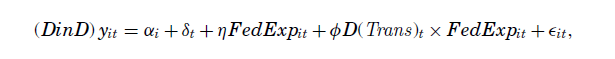
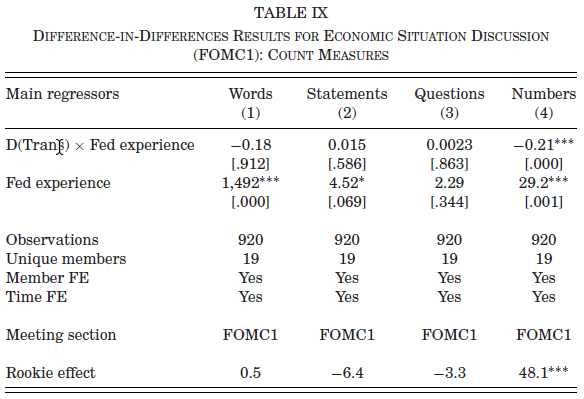
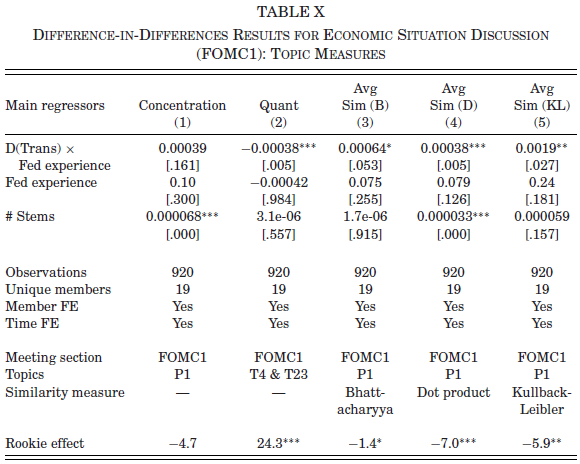
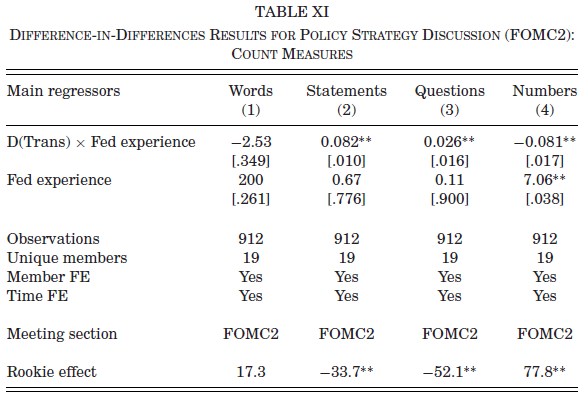
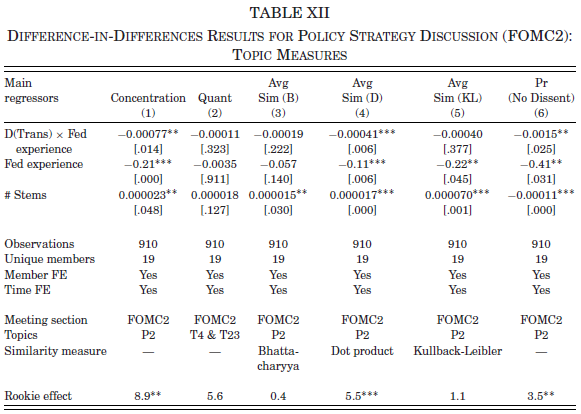